                                                                                                            Zachary Moore
                                                                                                            Fall 2018
                                                                                                            CptS 315
                                                                                                            Project Report

The dataset is composed of businesses, users, and business reviews by users. The original data files were in JSON format, but I changed it to CSV format after I reduced the size of the data and removing some columns. I used the recommender algorithm in order to recommend a number of restaurants to a select amount of users based on ratings from other users. 

# Recommender

First, the CSV data files need to be loaded into dataframes. Not all of the fields will be used in the dataframes which uses less memory. 

The businesses dataframe, bdf, contains various information about businesses. This project will use the name, business_id and is_open fields in order to display recommended businesses for a user. 

The users dataframe, udf, contains various information about users. Only user_id and name is used at the end of the project when displaying recommendations for users. The original data contained their names, but it was only the first names which would give duplicate names and be confusing. Since user_id is unique, it will be used with name to avoid confusion.

The reviews dataframe, rdf, contains information about business reviews made by users. The fields/columns being used are business_id, user_id, and stars. The text/comment field could be used for refining the algorithm later, but it wasn't be used for this project.

In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

path = './dataset/'
udf = pd.read_csv(path + 'dataset_user.csv')
bdf = pd.read_csv(path + 'dataset_business.csv')
rdf = pd.read_csv(path + 'dataset_review.csv')
rdf = rdf[['business_id','user_id','stars']]
udf = udf[['user_id','name']]
bdf = bdf[['business_id','name','is_open']]

Since I'm ignoring what the businesses are categorized as, business recommendations are made based solely on ratings of other businesses. Of course, this isn't very helpful when trying to give accurate recommendations to a user. 

One way to make it more accurate would be finding the category frequency of businesses that a user rated. After that, the recommender could give the user recommendations for a business in the category that they rated the most.

Another possible way would be reducing the data in the business dataset and review dataset to a certain category, such as restaurant, and giving recommendations to users that rated businesses in the category.

The next step in analyzing the data is creating a dataframe with the average rating for each business and the number of ratings.
The ratings are used to determine the correlation between the businesses. Below the following block of code is a histogram. The blue bars depict the number of businesses with average ratings between one and five (inclusively). The orange bars depict the frequency of ratings. For example, over 800 businesses have only one rating. 

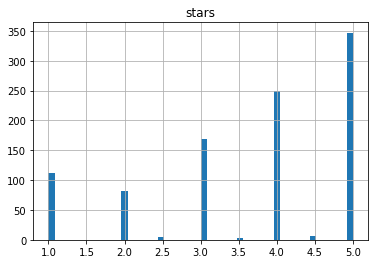

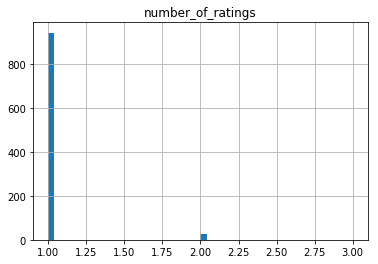

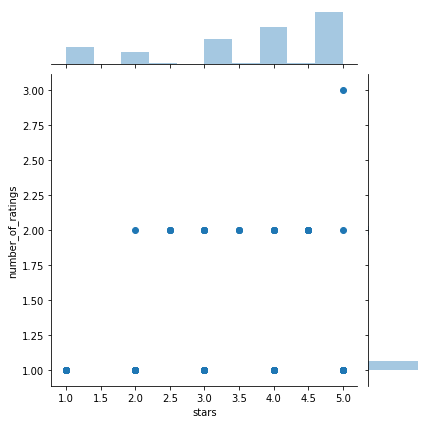

In [2]:
bus_ratings = rdf.groupby(['business_id'])['stars']
ratings = pd.DataFrame(bus_ratings.mean())
ratings['number_of_ratings'] = bus_ratings.count()

ratings.hist(bins=50,column='stars')
ratings.hist(bins=50,column='number_of_ratings')
sns.jointplot(x='stars',y='number_of_ratings',data=ratings)

According to the plot there are businesses with great ratings, but they were not rated many times. Because of that, the recommender doesn't work as effectively. In order to get around this, a minimum number of ratings is placed when the algorithm gives the recommendations. As one can see from the joint plot, the ratings become higher as the number of ratings increases.

In [4]:
bus_matrix = rdf.pivot_table(index='user_id',columns='business_id',values='stars')

uratings_dict = dict()
for bid in ratings.index:
    uratings_dict[bid] = bus_matrix[bid]

ratings_threshold = 1
for key in uratings_dict:
    sim = bus_matrix.corrwith(uratings_dict[key])
    corr = pd.DataFrame(sim,columns=['Correlation'])
    corr.dropna(inplace=True)
    corr = corr.join(ratings['number_of_ratings'])
    #corr[corr['number_of_ratings'] > ratings_threshold].sort_values(by='Correlation', ascending=False).head(10)